<a href="https://colab.research.google.com/github/cuixx289/STAT-6289_Homework/blob/master/HW4_Cui_Mingyang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing Deep Convolutional Generative Adversarial Networks (DCGANs) in Keras

Mingyang Cui

Nov 10/2020

# Dataset:

Face_data_new

From Kaggle: https://www.kaggle.com/gasgallo/faces-data-new

# Attribution Resource:

https://arxiv.org/abs/1511.06434 Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks, by Alec Radford, Luke Metz, Soumith Chintala, Cornell University 

https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_07_2_Keras_gan.ipynb by Instructor: Jeff Heaton, McKelvey School of Engineering, Washington University in St. Louis

Deep Convolutional Generative Adversarial Network: https://www.tensorflow.org/tutorials/generative/dcgan

Keep Calm and train a GAN. Pitfalls and Tips on training Generative Adversarial Networks: https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9

# Brief description of the project:
This project will use DCGANs to generate some face images similar to the face_new_data. These generated faces are not perfect, they demonstrate how we can construct and train a GAN on or own. 

# GAN Structure


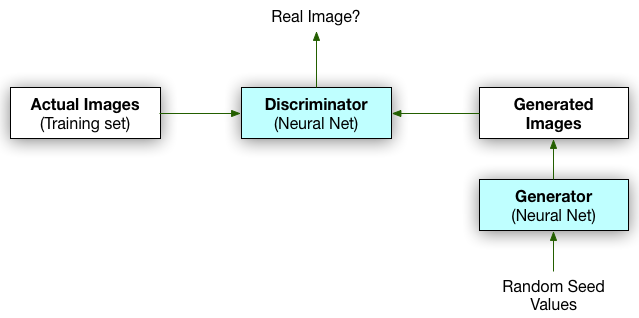

In [3]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

In [4]:
from google.colab import drive
import sys

# Mount Google Drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from tqdm import tqdm
import os 
import time
import matplotlib.pyplot as plt

# We will implements a DCGAN as follows:

No pre-processing was applied to training images besides scaling to the range of the tanh activation function [-1, 1].

All models were trained with mini-batch stochastic gradient descent (SGD) with a mini-batch size of 128.

All weights were initialized from a zero-centered Normal distribution with standard deviation 0.02.

In the LeakyReLU, the slope of the leak was set to 0.2 in all models.
we used the Adam optimizer(Kingma & Ba, 2014) with tuned hyperparameters. We found the suggested learning rate of 0.001, to be too high, using 0.0002 instead.

Additionally, we found leaving the momentum term $\beta{1}$ at the suggested value of 0.9 resulted in training oscillation and instability while reducing it to 0.5 helped stabilize training.

In [6]:
# Generation resolution - Must be square 
# Training data is also scaled to this.
# Note GENERATE_RES 4 or higher  
# will blow Google CoLab's memory and have not
# been tested extensivly.
GENERATE_RES = 3 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image 
PREVIEW_ROWS = 4
PREVIEW_COLS = 7
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/drive/My Drive/projects/faces/'
EPOCHS = 100
BATCH_SIZE = 32
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Will generate 96px square images.


In [7]:
# Image set has 11,682 images, it takes an hour to load the training images.   
# for initial preprocessing.
# Because of this time needed, save a Numpy preprocessed file.
# Note, that file is large enough to cause problems for 
# sume verisons of Pickle,
# so Numpy binary files are used.
training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH,'face_images')
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

Looking for file: /content/drive/My Drive/projects/faces/training_data_96_96.npy
Loading previous training pickle...



We will use a TensorFlow Dataset object to actually hold the images. This allows the data to be quickly shuffled int divided into the appropriate batch sizes for training.

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


# Figure 7.GAN-EVAL: Evaluating GANs

The GAN is made up of two different neural networks: the discriminator and the generator. The generator generates the images, while the discriminator detects if a face is real or was generated. These two neural networks work as shown in Figure 7.GAN-EVAL:

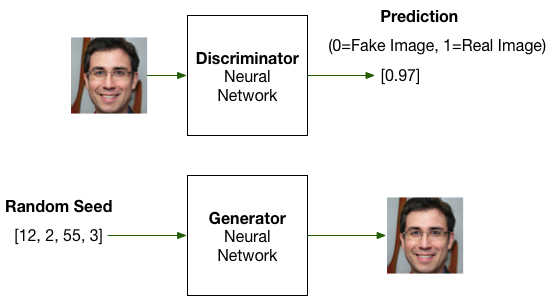

# Generator function and Discriminator function

The architecture of buiding generator and discriminator function for our DCGANs models are following:

1.Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).

2.Use batchnormalization in both the generator and the discriminator to prevent the vanishing gradient problem.

3.Remove fully connected hidden layers for deeper architectures.

4.Use ReLU activation in generator for all layers except for the output, which uses Tanh.

5.Use LeakyReLU activation in the discriminator for all layers.


In [9]:
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model


def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

# Save training images
As we progress through training images will be produced to show the progress. These images will contain a number of rendered faces that show how good the generator has become. These faces will be

In [10]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

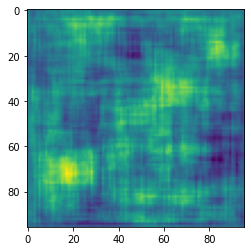

In [11]:

generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

In [12]:
image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.4995191]], shape=(1, 1), dtype=float32)


#Loss function

The generator and discriminator must be trained in an adversarial way in order to develope the Loss functions.

This requires two separate loss functions respect to generator and discriminator. Also, these two functions separate updates to the gradients. When the discriminator's gradients are applied to decrease the discriminator's loss it is important that only the discriminator's weights are update. It is not fair, nor will it produce good results, to adversarially damage the weights of the generator to help the discriminator. A simple backpropagation would do this. It would simultaneously affect the weights of both generator and discriminator to lower whatever loss it was assigned to lower.

# Training the Discriminator

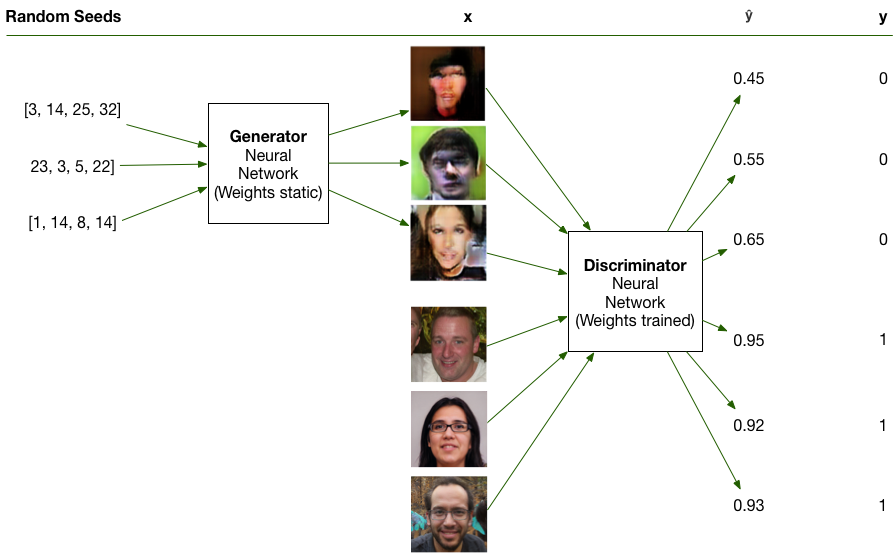

Above image shows the procedure of a training set is generated with an equal number of real and fake images. The real images are randomly chosen from the training data. An equal number of random images are generated from random seeds. For the discriminator training set, the $x$ contains the input images and the $y$ contains a value of 1 for real images and 0 for generated ones.

# Training the Generator

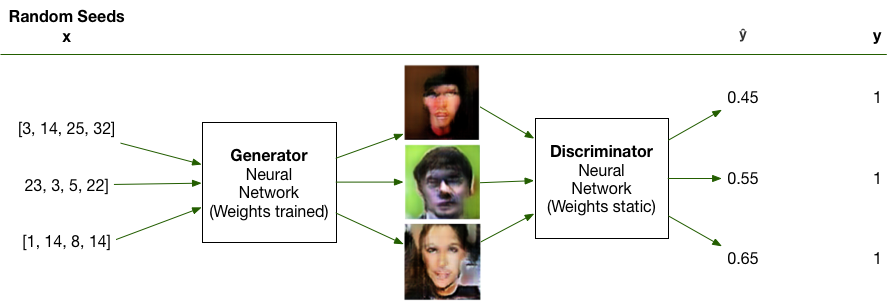

For the generator training set, the $x$ contains the random seeds to generate images and the $y$ always contains the value of 1, because the optimal is for the generator to have generated such good images that the discriminiator was fooled into assigning them a probability near 1.

In [13]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

#Optimizer

Both the generator and discriminator use Adam optimizer and the same learning rate (0.5) and momentum. This does not need to be the case. If you use a GENERATE_RES greater than 3 you may need to tune these learning rates, as well as other training and hyperparameters.



In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)


The function below gives us where discriminator and generator's training takes place. This function was based on the GAN provided by the TensorFlow Keras exmples documentation. The first thing you should notice about this function is that it is annotated with the tf.function annotation. This causes the function to be precompiled and improves performance.

This function trans differently than the code we previously saw for training. This code makes use of GradientTape to allow the discriminator and generator to be trained together, yet separately.

In [15]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

In [16]:
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

In [17]:
train(train_dataset, EPOCHS)

Epoch 1, gen loss=2.938873529434204,disc loss=0.860725998878479, {hms_string(epoch_elapsed)}
Epoch 2, gen loss=3.4694981575012207,disc loss=0.8231568336486816, {hms_string(epoch_elapsed)}
Epoch 3, gen loss=3.3997323513031006,disc loss=0.7415246963500977, {hms_string(epoch_elapsed)}
Epoch 4, gen loss=2.8461802005767822,disc loss=0.9893006682395935, {hms_string(epoch_elapsed)}
Epoch 5, gen loss=2.7102200984954834,disc loss=0.8706514239311218, {hms_string(epoch_elapsed)}
Epoch 6, gen loss=2.88981294631958,disc loss=0.8519217371940613, {hms_string(epoch_elapsed)}
Epoch 7, gen loss=2.963899612426758,disc loss=0.7836754322052002, {hms_string(epoch_elapsed)}
Epoch 8, gen loss=2.959261655807495,disc loss=0.7884173393249512, {hms_string(epoch_elapsed)}
Epoch 9, gen loss=2.9209375381469727,disc loss=0.7532538771629333, {hms_string(epoch_elapsed)}
Epoch 10, gen loss=2.9998745918273926,disc loss=0.7137853503227234, {hms_string(epoch_elapsed)}
Epoch 11, gen loss=3.088595390319824,disc loss=0.692796

In [ ]:
generator.save(os.path.join(DATA_PATH,"face_generator.h5"))

# Result

Figure of train-0

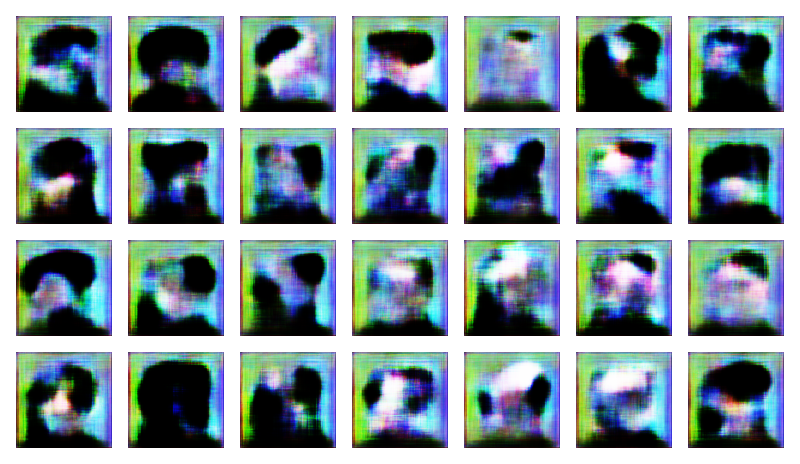

Figure of train-5

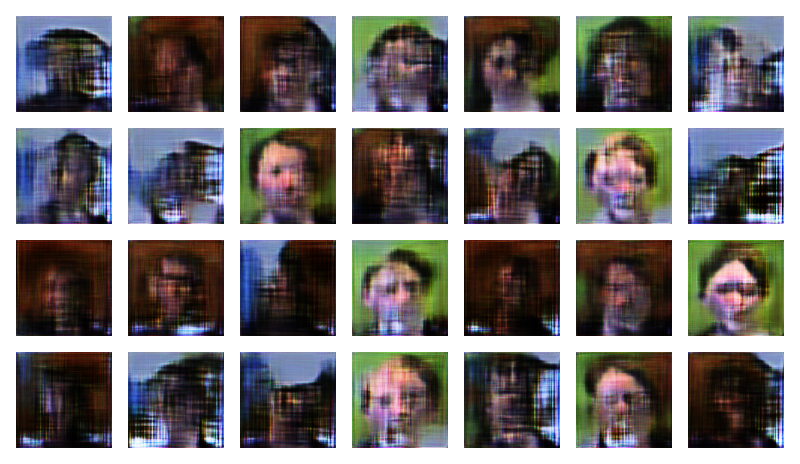

Figure of train-65

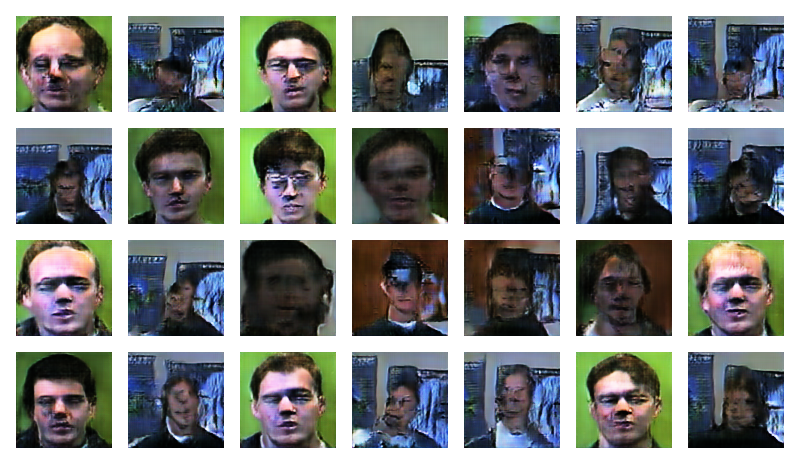

Figure of train-99

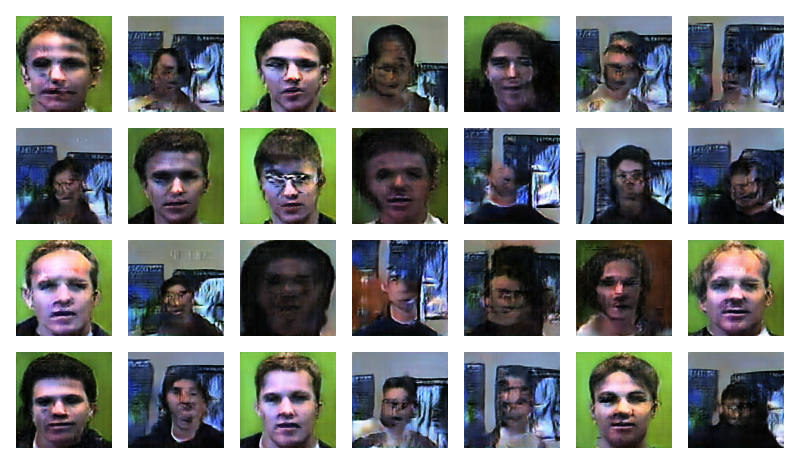

From the output images (from train 0 to train 99) shows above, we can conclude that as we train more times or increase epoch value, the faces drawn by our generator--they look more and more realistic.


# What I learned from this project?

From this implementation, I find that the original code gives us the discriminator's activation function is sigmoid. If I change the activation function to softmax, the discriminator does not work. Because the discriminator uses sigmoid function to take an image in and output a binary (True/False) result. 

In addition, the resolution of our generated face images are low, if we need Higher resolution images, we need use StyleGAN2 to generate. I could compare these two methods in my final project.  